# Capstone Project: Empirical REIT Pricing via Machine Learning
by Ethan Leow

In [1]:
# Load libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

## Problem statement
I am a portfolio manager at a real estate fund of funds, and I am intrigued by recent publications in academia on machine learning and asset pricing. According to Campbell and Thompson (2008), small improvements in $R^{2}$ can lead to large improvements in performance for a mean-variance investor. They show that the proportionate increase in expected excess return earned by an active investor exploiting predictive information is
\begin{equation*}
\frac{R^{2}}{(1+R^{2})}\frac{(1+S^{2})}{S^{2}} 
\end{equation*}
, where $R^{2}$ is the predictive R-squared statistic and $S$ is the Sharpe ratio earned by a passive buy-and-hold investor. To put in another way, the Sharpe ratio $S\ast$ earned by an active investor with predictive capability is
\begin{equation*}
S\ast = \sqrt{\frac{S^{2} + R^{2}}{1 - R^{2}}}  
\end{equation*}

Sharpe ratio describes how much excess return an investor's portfolio receives for the volatility he has to endure for holding on to that portfolio, and it is how my performance as a portfolio manager is assessed by my clients. Sharpe ratio is formally defined as
\begin{equation*}
S = \frac{r_{p} - r_{f}}{\sigma_{p}}
\end{equation*},
where $r_{p}$ is the return on the investor's portfolio, $r_{f}$ is the return of a risk-free security e.g. U.S. Treasury bills (even though some might argue US treasuries are no longer the gold-standard for a risk-free security, with Senate Republicans playing fire with Democrats over their refusal to raise the debt ceiling recently), and $\sigma_{p}$ is the standard deviation of  $r_{p}$.

My job is to improve my portfolio's Sharpe ratio by finding better ways to assemble my portfolio of real estate stocks to beat my competitors and my benchmark index, i.e. the FTSE Nareit U.S. Real Estate Index Series which tracks the performance of the U.S. REIT industry starting January 1972. I am encouraged by the recent findings of Gu, Kelly and Xiu (2020) who state that a portfolio that executes market timing on S&P 500 stocks using neural network forecasts enjoys an annualized (out-of-sample) Sharpe ratio of 0.77, as opposed a Sharpe ratio of 0.51 enjoyed by a passive buy-and-hold investor of the S&P 500 index. This is a more than 50% improvement in the risk-return tradeoff. 

My goal is two-fold: improve predictions in the cross-section and time series of REIT returns. I shall study a set of candidate models to address my empirical challenges, starting with linear regression, generalized linear models with penalization, dimension reduction via principal component regression (PCR) and partial least squares (PLS), regression trees (including random forests and boosted trees), neural networks and other deep learning techniques that I will be learning in the weeks to come. This is not an exhaustive list of all machine learning methods, but one designed to be representative of predictive analytics tools from various branches of the machine learning universe.

In [2]:
0.77 / 0.51 - 1

0.5098039215686274

## Proposed methods and models

### Data

In his presidential address to American Finance Association, John Cochrane (2011) challenges researchers to identify features that provide _independent_ information about the cross-section of U.S. stock returns. Green, Hand and Zhang (2017) took up the challenge and came up with 94 features that have since been used as a baseline by a number of leading academics for subsequent research. They offer a SAS code on their [website](https://sites.google.com/site/jeremiahrgreenacctg/home) to create these 94 firm characteristics but it seems like I need to request access from Jeremiah Green and learn to convert the code from SAS to Python. Hope the conversion exercise is not a big obstacle, as I have no experience with SAS coding. See **df_factors** below for a description of the firm features that I intend to use.

Separately, in their seminal paper which won the Michael Brennan Award for Best Paper at the Review of Financial Studies, Welch and Goyal (2008) constructed fourteen macroeconomic predictors that have also been used by a number of publications since. Fortunately, there is no need to convert any SAS code this time. Goyal freely posts his data on his [website](https://sites.google.com/view/agoyal145) in a cleaned and friendly format. See **df_macro** below for the data updated to 2020.

I will obtain monthly individual REIT returns from CRSP for all REITs listed in the NYSE, AMEX and NASDAQ starting January 1972, as that is the official start date of the FTSE Nareit U.S. Real Estate Index which is the benchmark my models will be compared with. I will obtain Treasury-bill rate and the Fama-French factors from Kenneth French's [website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) that all business and economics college students use.

In [3]:
# Show 94 features from Green, Hand and Zhang (2017)
url = '../data/green_hand_zhang_journal_article.html'
soup = BeautifulSoup(open(url).read())

# Extract features from html file
df_factors = []
for element in soup.find_all('table')[38].find('tbody').find_all('tr'):
    factor = {}
    factor['Feature acronym'] = element.select('td')[0].get_text(strip=True)
    factor['Original author(s)'] = element.select('td')[1].get_text(strip=True)
    factor['Date, journal'] = element.select('td')[2].get_text(strip=True)
    factor['Description of feature'] = element.select('td')[3].get_text(strip=True)
    df_factors.append(factor)

    
# Show features
pd.set_option('display.max_rows', None)
df_factors = pd.DataFrame(df_factors)
df_factors

,Feature acronym,Original author(s),"Date, journal",Description of feature
0,absacc,"Bandyopadhyay, Huang, and Wirjanto","2010, WP",Absolute value ofacc
1,acc,Sloan,"1996, TAR",Annual income before extraordinary items (ib) ...
2,aeavol,"Lerman, Livnat, and Mendenhall","2008, WP",Average daily trading volume (vol) for 3 days ...
3,age,"Jiang, Lee, and Zhang","2005, RAS",Number of years since first Compustat coverage
4,agr,"Cooper, Gulen, and Schill","2008, JF",Annual percent change in total assets (at)
5,baspread,Amihud and Mendelson,"1989, JF",Monthly average of daily bid-ask spread divide...
6,beta,Fama and MacBeth,"1973, JPE",Estimated market beta from weekly returns and ...
7,betasq,Fama and MacBeth,"1973, JPE",Market beta squared
8,bm,"Rosenberg, Reid, and Lanstein","1985, JPM",Book value of equity (ceq) divided by end of f...
9,bm_ia,"Asness, Porter, and Stevens","2000, WP",Industry adjusted book-to-market ratio


In [4]:
# Show 14 macroeconomic predictors from Welch and Goyal (2008)
df_macro = pd.read_excel('../data/goyal_PredictorData2020.xlsx')

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
df_macro

/Users/lijunandkahshin/opt/anaconda3/envs/tensordsi24/lib/python3.7/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,yyyymm,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
0,187101,4.44,0.260000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102,4.50,0.260000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,0.004967,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187103,4.61,0.260000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,0.004525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187104,4.74,0.260000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,0.004252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187105,4.86,0.260000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,0.004643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,202008,3500.31,59.128628,98.556667,0.235975,0.0010,0.0225,0.0327,0.0065,-0.008504,0.000100,0.003153,-0.0349,-0.0488,0.000743,NaN,0.072068,0.070308
1796,202009,3363.00,58.851237,98.220000,0.241482,0.0011,0.0231,0.0336,0.0068,-0.005698,0.000100,0.001393,0.0080,0.0041,0.004907,NaN,-0.038151,-0.039366
1797,202010,3269.96,58.660440,96.856667,0.253146,0.0010,0.0235,0.0344,0.0079,-0.001895,0.000100,0.000415,-0.0238,-0.0190,0.003661,NaN,-0.026409,-0.027507
1798,202011,3621.63,58.469643,95.493333,0.226352,0.0009,0.0230,0.0330,0.0087,-0.005262,0.000100,-0.000611,0.0093,0.0509,0.002492,NaN,0.109403,0.107623


### Methodology

Let a REIT's excess return be described as $r_{i, t+1} = E_{t}(r_{i, t+1}) + \epsilon_{i, t+1}$ where $E_{t}(r_{i, t+1}) = g(z_{i, t})$. My job is to find functions of predictor variables / features that maximizes the out-of-sample explanatory power for realizations of $r_{i, t+1}$. I denote those predictors as a multi-dimensional vector $z_{i, t}$ and assume the conditional expected return $g(\ast)$ is a flexible function of those predictors, i.e. it need not be linear functions such as the Fama-French 3-factor model or the Carhart 4-factor model that we are taught in school.

I further denote $z_{i, t} = c_{i,t} \times x_{t}$ where $c_{i,t}$ is a vector of the 94 Green, Hand and Zhang (2017) characteristics / features and $x_{t}$ is a vector of the 14 Welch and Goyal (2008) macroeconomic predictors (and are thus common to all REITS, including a constant). Thus $z_{i, t}$ is a vector of all features for predicting an individual REIT returns and includes interactions between REIT-level features and macroeconomic state variables. The total number of covariates is therefore 94 x (14 + 1) = 1410.

Next, I divide 48 years of data (1972 to 2020) into 24 years of training sample (1972-1995), 12 years of validation sample (1996-2007) and 12 years for out-of-sample testing (2008 - 2020).
In terms of refitting my models, although my returns time series is on a monthly basis, I think I will avoid recursively refitting each month as I think machine learning algorithms (especially deep learning ones that I will learn in weeks to come) are computationally- and time- intensive. I will probably refit once every year since Compustat/CRSP's fundamental data are typically refreshed once a year or once a quarter, according to Fama-French (1993). I maintain the same size of validation sample and roll it forward to include the most recent 12 months.

As a robustness check, I will also conduct another train-validate-test run for the 1993-2020 period as, 1993 is generally considered the inception of the “modern REIT era” marked by the introduction of the UPREIT legislation. This period of 27 years will be split into 3 x 9 years, with train set being 1993-2001, validation set being 2002-2010, and test set being 2011-2020. This is to address a potential issue that the underlying distribution of REIT returns is structurally different pre- and post-1993.

A reference point for end-results would be the tables and figures produced by Gu, Kelly and Xiu (2020) but mine will be a bit more comprehensive with more columns for recent advances / models in deep learning (as suggested by Ryan). See below.


<div>
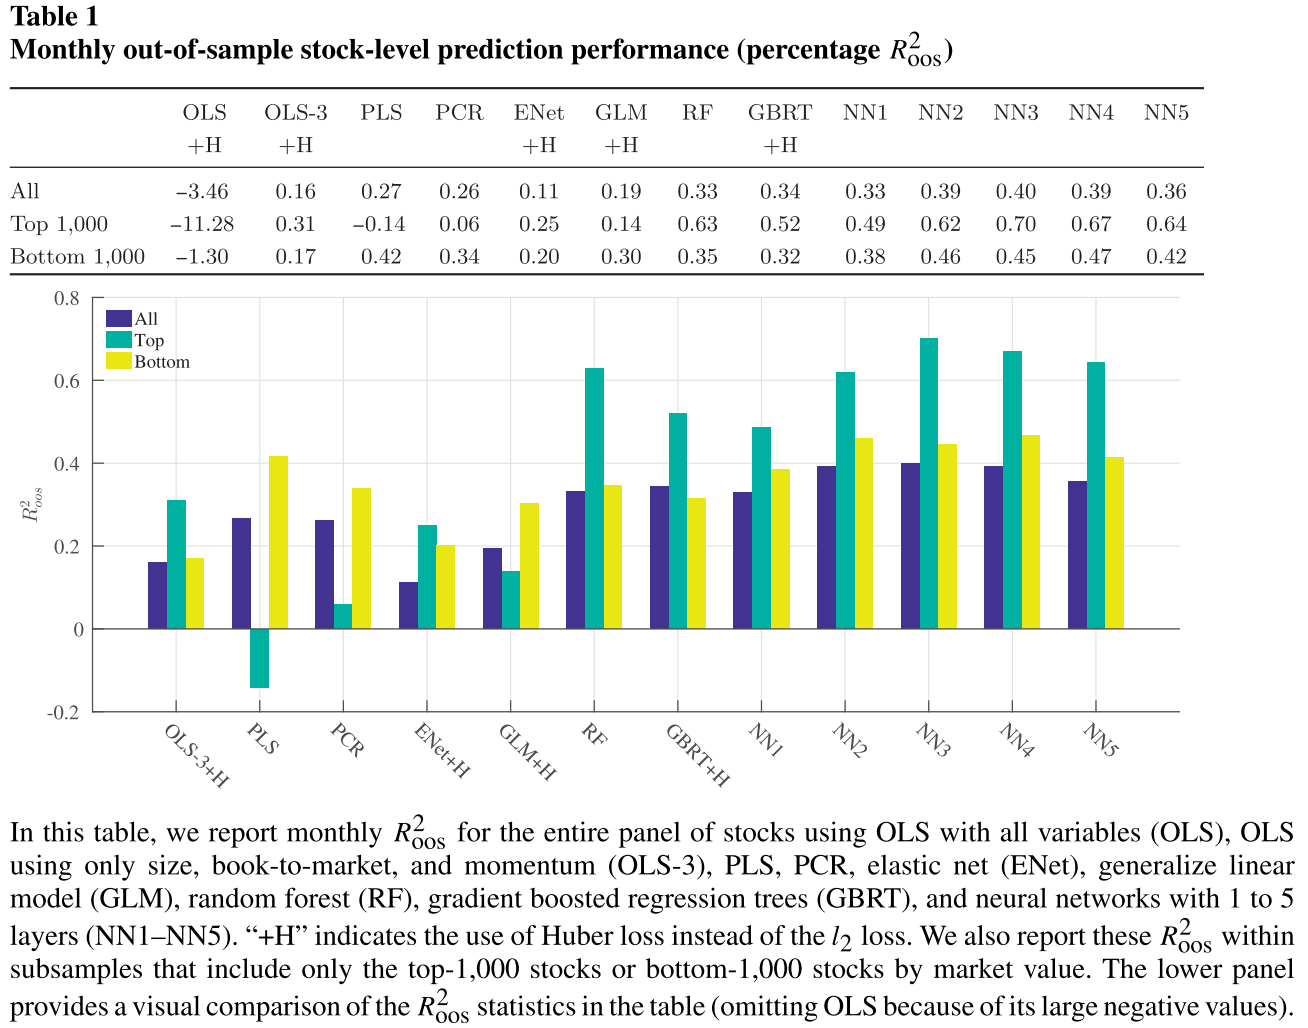
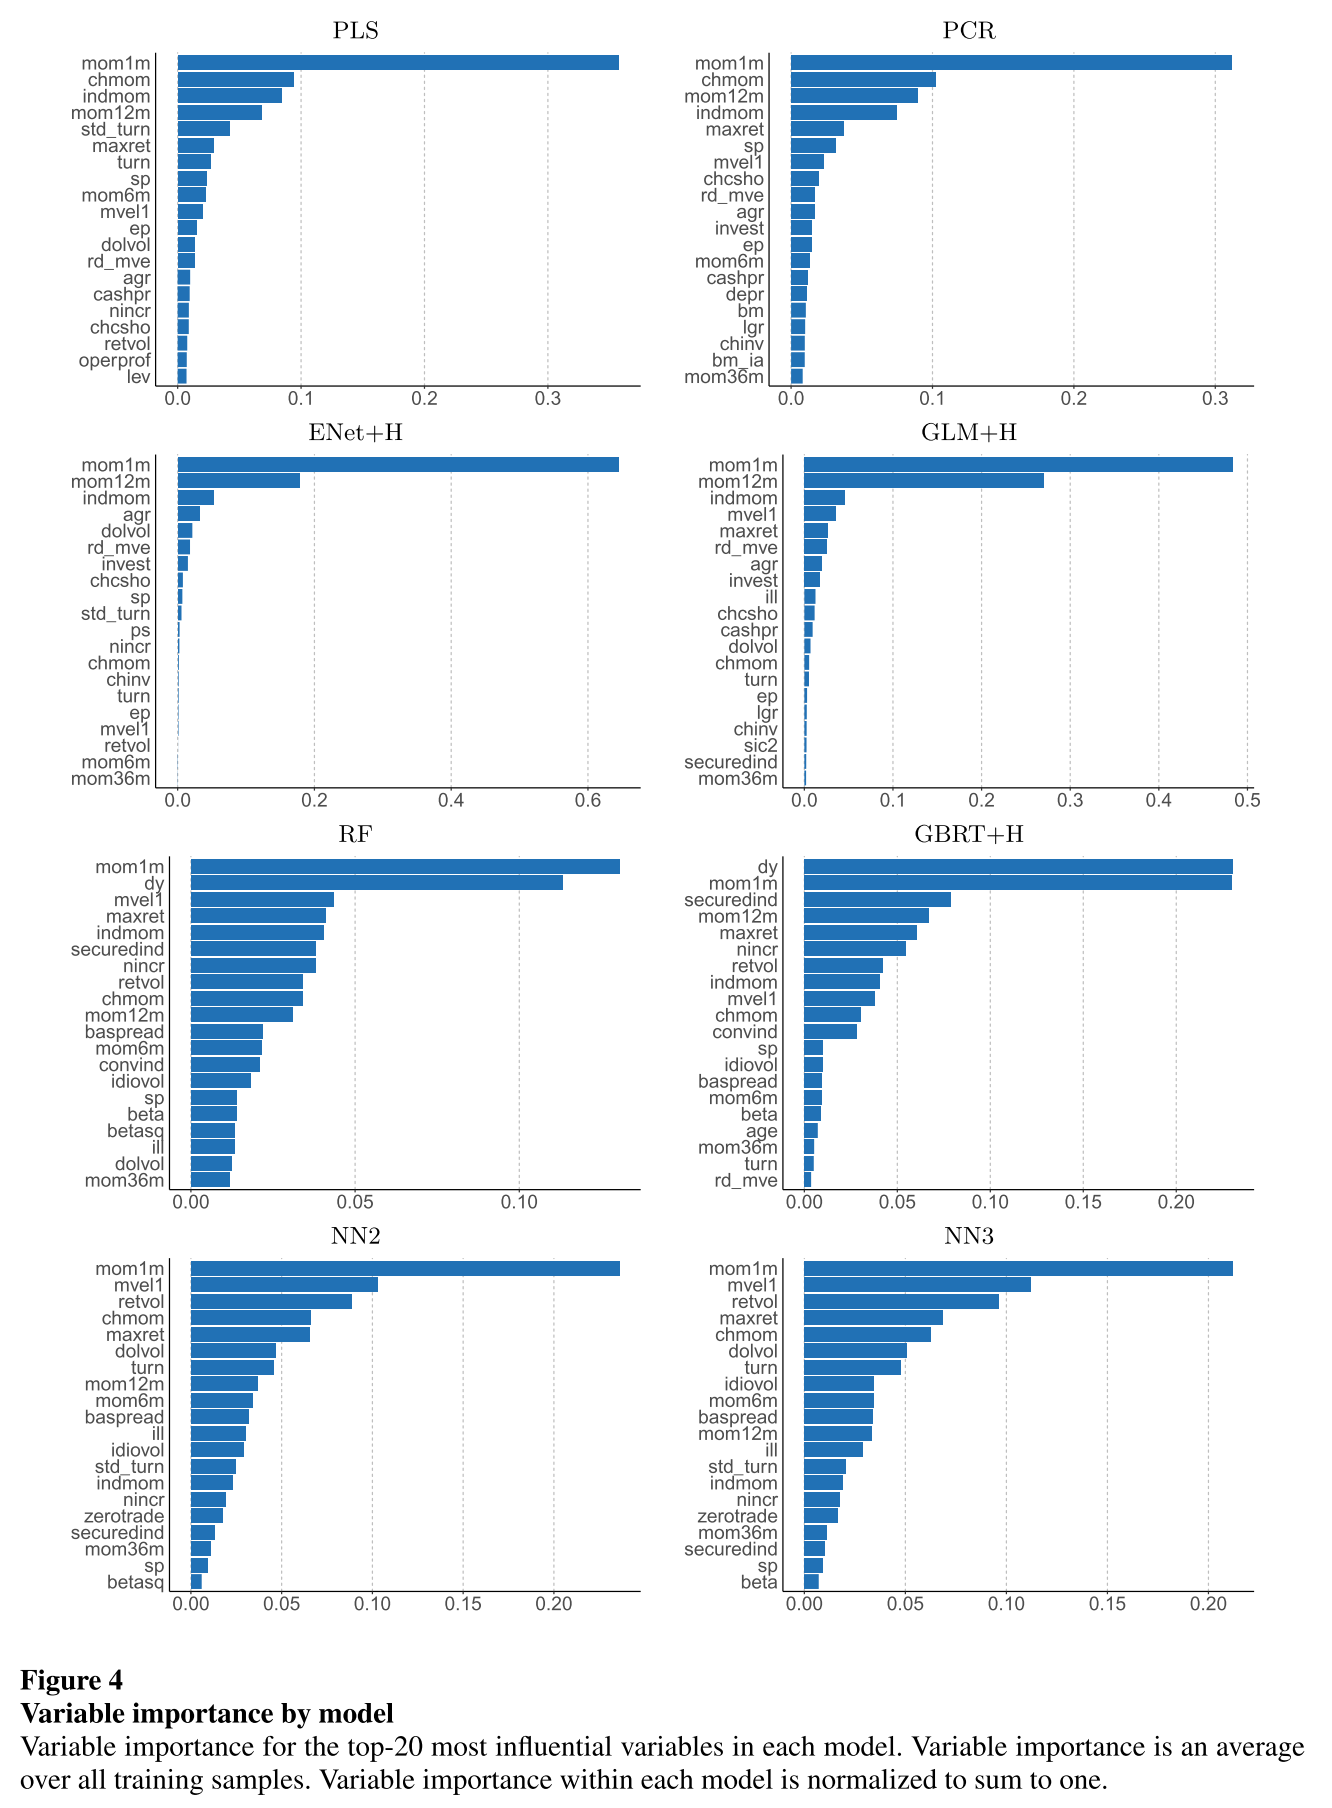
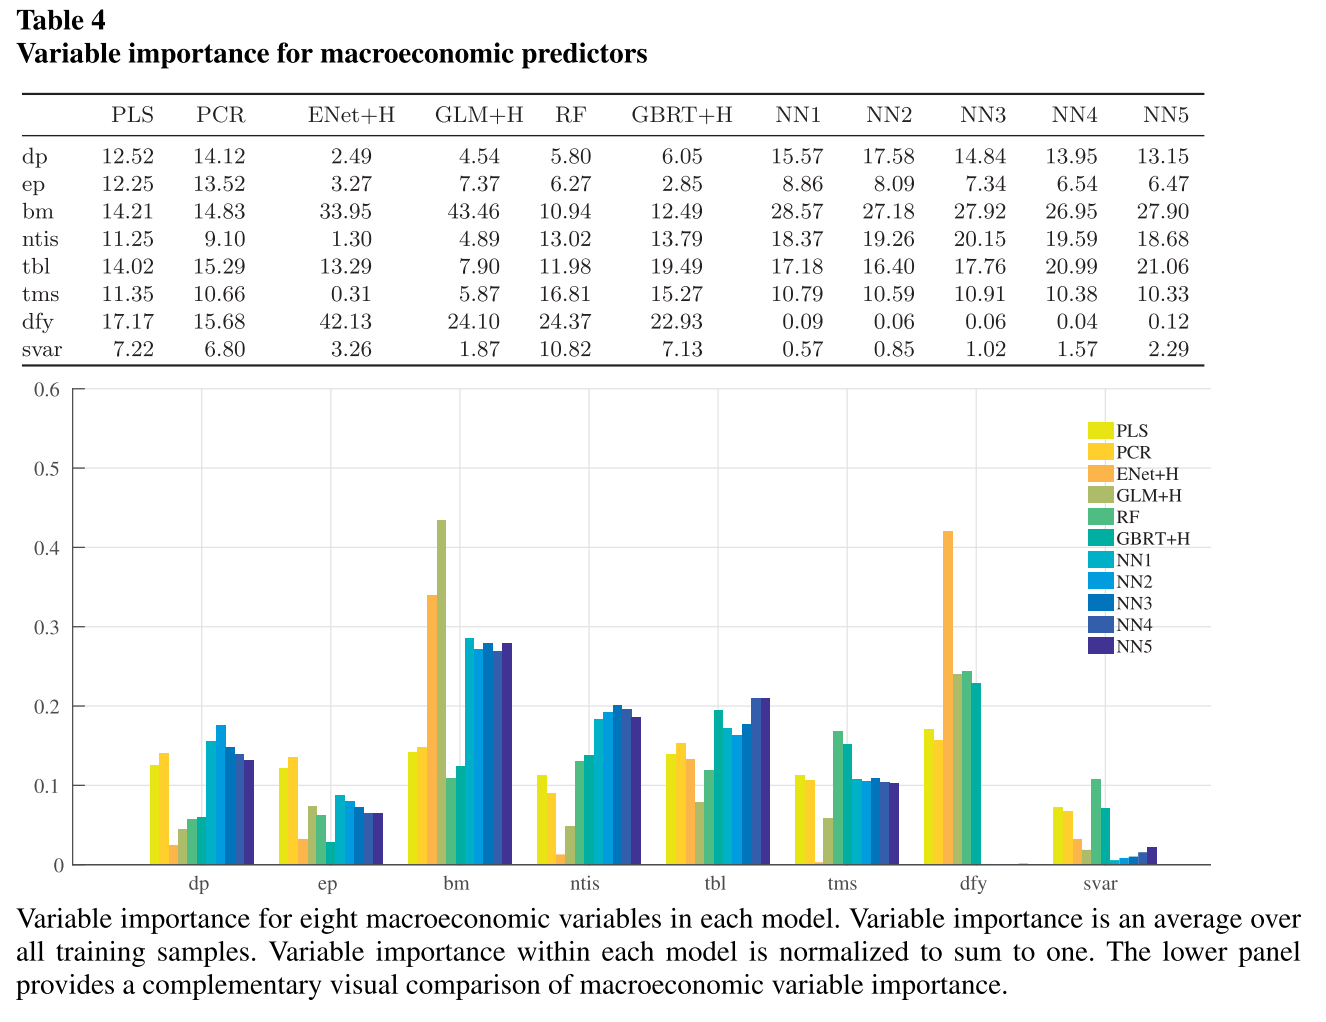
</div>

I expect very different findings from Gu, Kelly and Xiu (2020) as real estate in itself is a very different asset class from stocks. There is an abundance of literature spanning a few decades discussing differences between stocks and real estate. REITs are a direct translation of real estate even though they are traded on the stock markets, as REITs are required by legislation to pay out more than 90% of their rental income and investment gains to shareholders, which means that holding onto REITs are no different from holding onto the actual underlying properties themselves.
I would also expect very different non-linear interaction effects for real estate that can be elucidated by complex models such as trees and neural networks. The figures below are illustrations of non-linear effects can be possibly produced from my work.

<div>
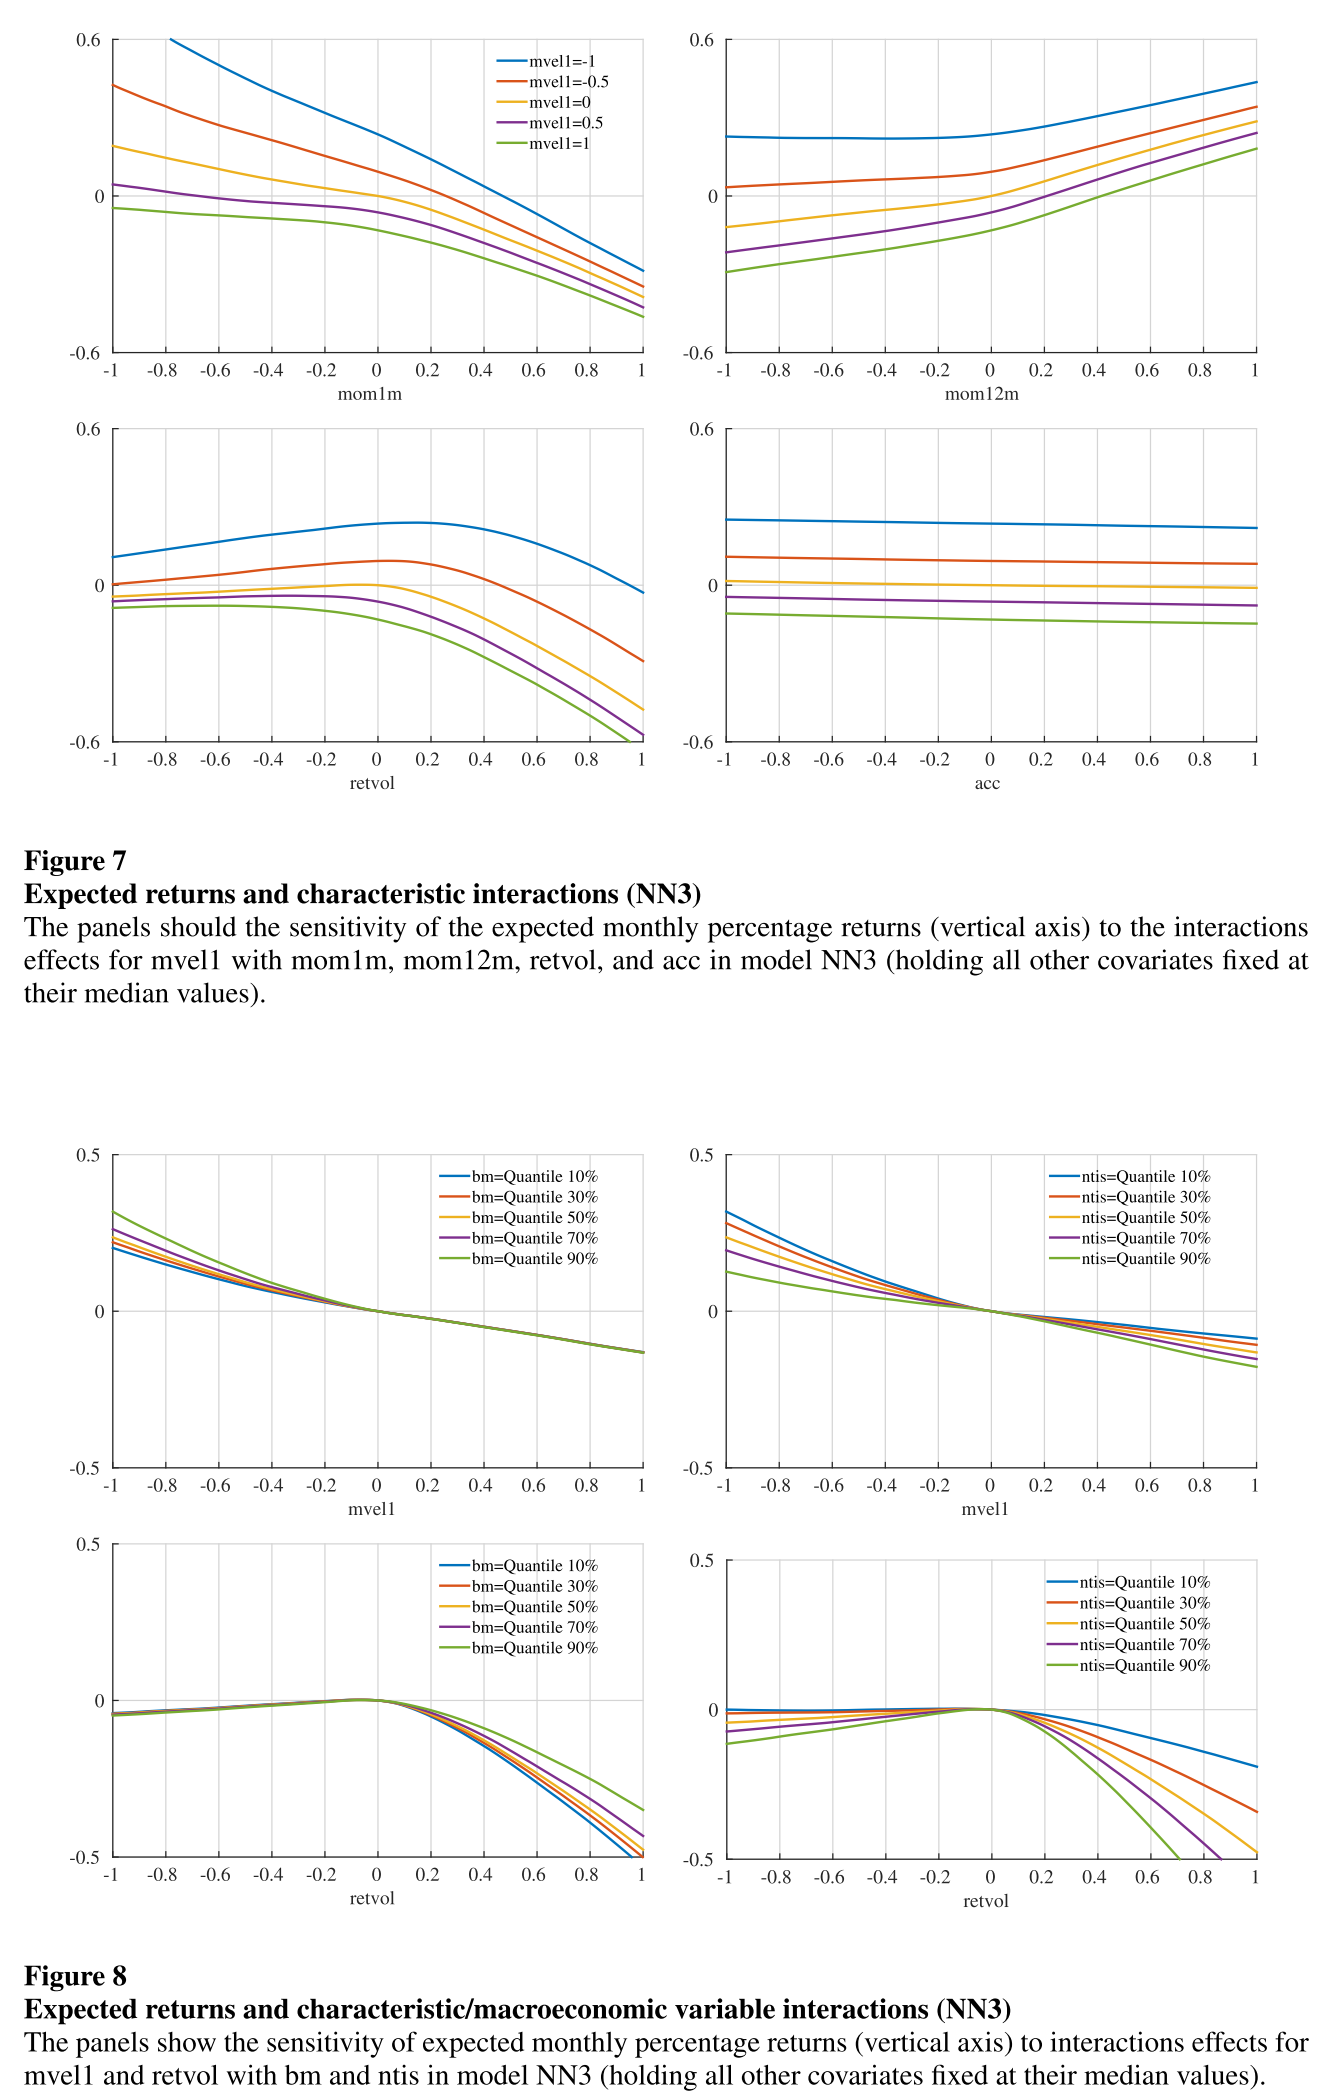
</div>

Finally, the end goal is to show a convincing gain by machine learning models over traditional OLS and generalized linear models for real estate portfolio management. The table below is an illustration of what I hope to produce by the end of my project. In this section, I shall attempt to form bottom-up forecasts for 30 of the most well-known portfolios in finance literature, including Fama-French size, value, profitability, investment, and momentum factor portfolios (SMB, HML, RMW, CMA, and UMD, respectively), and subcomponents of these Fama-French portfolios (six size and value portfolios, six size and investment portfolios, six size and profitability portfolios, and six size and momentum portfolios). However, if time or my programming capabilities are limited, I may drop some of them and just go with a small fraction instead.

<div>
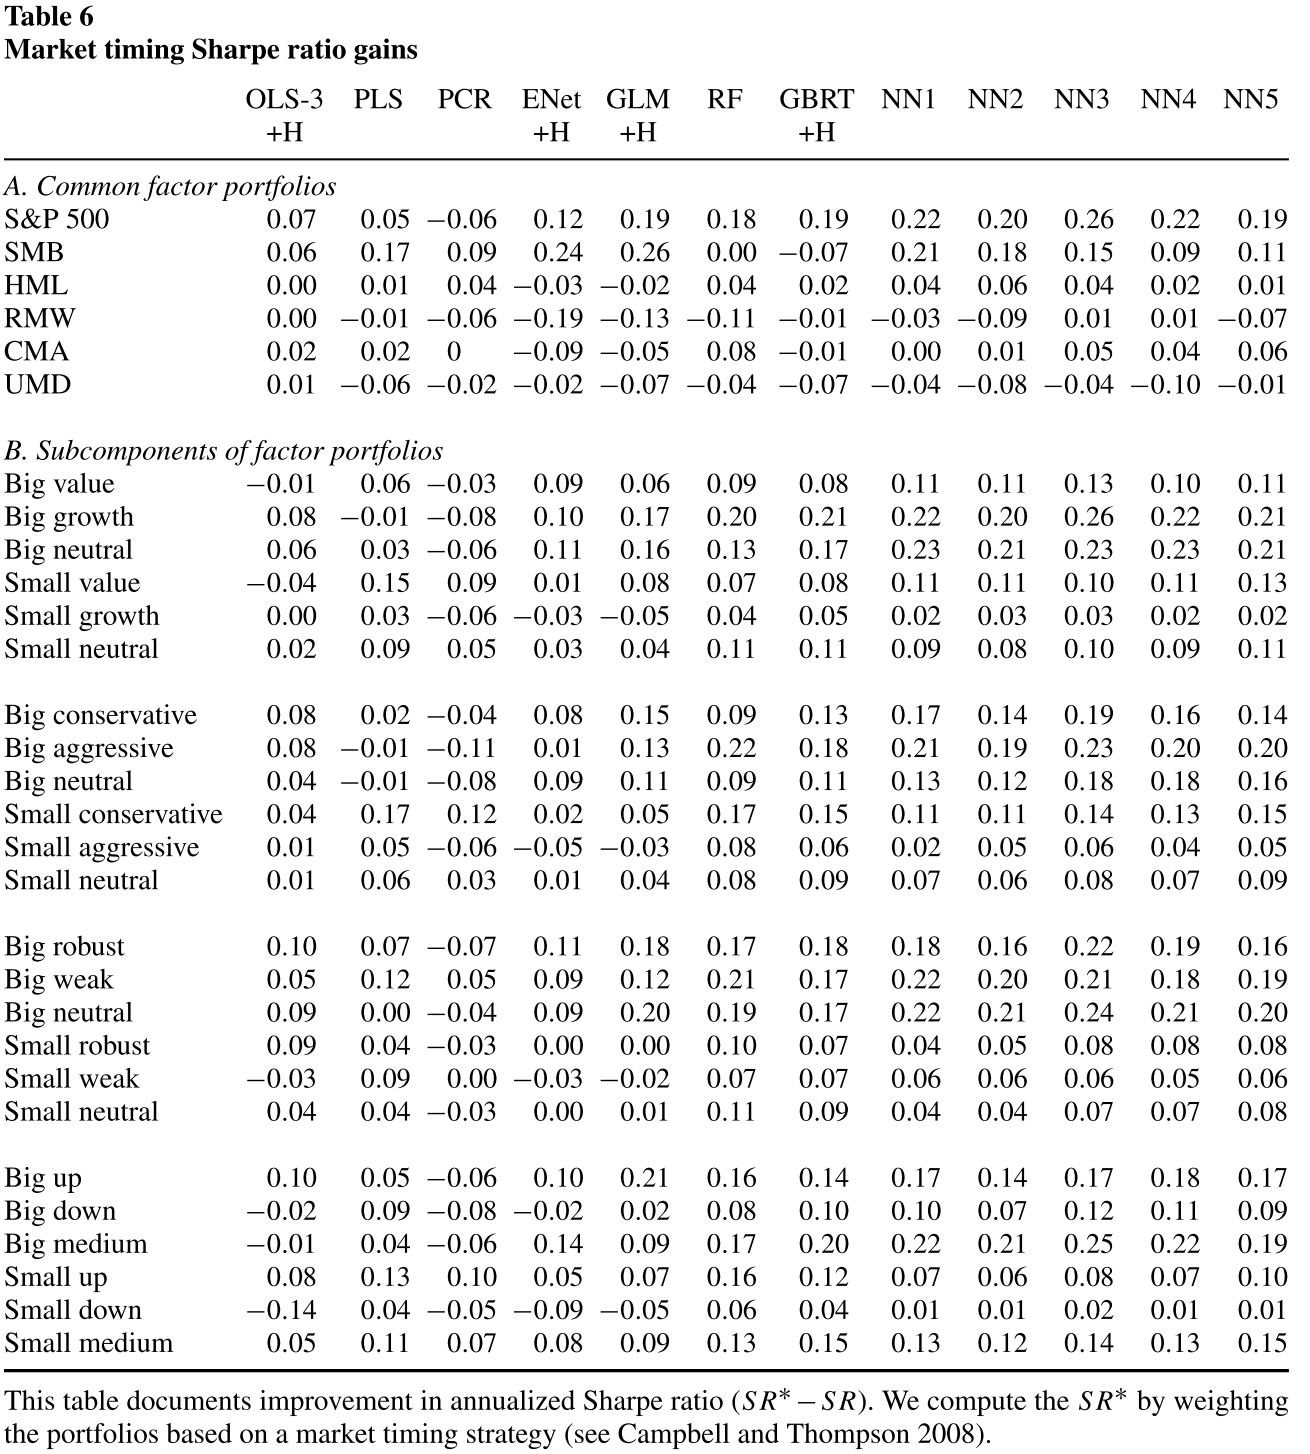
</div>

In [5]:
94*(14+1)

1410

## Risks and assumptions of data

My biggest risk is Jeremiah Green refusing to grant me access to his SAS code to recreate the 94 firm features. Assuming he agrees to my request, my next risk is my inability to learn SAS fast enough to adapt it to Python code for my usage.

## Goals and success criteria

In addition to using $R^{2}$s as predictors of success for my models since that translate directly into improvements in Sharpe ratio, I will also use MSEs as predictors of success.

## References
Campbell J. Y., and S. B. Thompson. 2008. Predicting excess stock returns out of sample: Can anything beat the historical average? _Review of Financial Studies_

Chen L. (Stanford University), M. Pelger (Stanford University), and J. Zhu (Stanford University). 2021. Deep Learning in Asset Pricing _Working Paper_

Cochrane, J. H. 2011. Presidential address: Discount rates. _Journal of Finance_

Fama, E. F., and K. R. French. 1993. Common risk factors in the returns on stocks and bonds. _Journal of Financial Economics_

Feng G. (City University of Hong Kong), N. Polson (University of Chicago) and J. Xu (University of Chicago). 2021. Deep Learning in Characteristics-Sorted Factor Models _Working Paper_

Green, J., J. R. M. Hand, and X. F. Zhang. 2017. The characteristics that provide independent information about average us monthly stock returns. _Review of Financial Studies_ 

Gu S., B. Kelly, and D. Xiu. 2020. Empirical Asset Pricing via Machine Learning _Review of Financial Studies_ 

Welch, I., and A. Goyal. 2008. A comprehensive look at the empirical performance of equity premium prediction. _Review of Financial Studies_ 